In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:

def is_valid_image(file_path):
    try:
        with open(file_path, 'rb') as f:
            img_bytes = f.read()
            img = Image.open(io.BytesIO(img_bytes))
            img.verify()
            if img.mode not in ('RGB', 'L'):  
                return False
        return True
    except:
        return False


In [ ]:

def load_and_clean_data():
    cat_files = [os.path.join('PetImages/Cat', f) for f in os.listdir('PetImages/Cat') 
                if f.lower().endswith(('.jpg', '.jpeg', '.png')) and 
                is_valid_image(os.path.join('PetImages/Cat', f))]
    
    dog_files = [os.path.join('PetImages/Dog', f) for f in os.listdir('PetImages/Dog') 
                if f.lower().endswith(('.jpg', '.jpeg', '.png')) and 
                is_valid_image(os.path.join('PetImages/Dog', f))]

    print(f"Found {len(cat_files)} valid cat images")
    print(f"Found {len(dog_files)} valid dog images")

    df = pd.DataFrame({
        'filename': cat_files + dog_files,
        'class': ['cat']*len(cat_files) + ['dog']*len(dog_files)
    })
    return df


In [ ]:

def create_generators(df):
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

    validation_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary',
        shuffle=False)

    return train_generator, validation_generator


In [ ]:

def build_and_train_model(train_generator, validation_generator):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2, input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // 32,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // 32)

    return model, history


In [ ]:

def evaluate_and_visualize(model, validation_generator):
    val_loss, val_acc = model.evaluate(validation_generator)
    print(f"\nValidation accuracy: {val_acc:.3f}")

    test_images, test_labels = next(validation_generator)
    predictions = model.predict(test_images)
    predicted_classes = (predictions > 0.5).astype("int32")

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i])
        plt.title(f"Pred: {'dog' if predicted_classes[i][0] == 1 else 'cat'}\nTrue: {'dog' if test_labels[i] == 1 else 'cat'}")
        plt.axis("off")
    plt.show()


Found 12473 valid cat images
Found 12463 valid dog images
Found 19948 validated image filenames belonging to 2 classes.
Found 4988 validated image filenames belonging to 2 classes.
Epoch 1/10
349/623 [===============>..............] - ETA: 16s - loss: 0.6342 - accuracy: 0.6324

c:\Users\ASLAM\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


623/623 [==============================] - 45s 70ms/step - loss: 0.6010 - accuracy: 0.6698 - val_loss: 0.5469 - val_accuracy: 0.7246
Epoch 2/10
623/623 [==============================] - 41s 66ms/step - loss: 0.5108 - accuracy: 0.7500 - val_loss: 0.5009 - val_accuracy: 0.7556
Epoch 3/10
623/623 [==============================] - 41s 66ms/step - loss: 0.4641 - accuracy: 0.7810 - val_loss: 0.4641 - val_accuracy: 0.7760
Epoch 4/10
623/623 [==============================] - 42s 67ms/step - loss: 0.4209 - accuracy: 0.8096 - val_loss: 0.4498 - val_accuracy: 0.7865
Epoch 5/10
623/623 [==============================] - 41s 66ms/step - loss: 0.3903 - accuracy: 0.8217 - val_loss: 0.4262 - val_accuracy: 0.7988
Epoch 6/10
623/623 [==============================] - 41s 66ms/step - loss: 0.3562 - accuracy: 0.8388 - val_loss: 0.4158 - val_accuracy: 0.8131
Epoch 7/10
623/623 [==============================] - 41s 66ms/step - loss: 0.3222 - accuracy: 0.8581 - val_loss: 0.4849 - val_accuracy: 0.7946
Epo

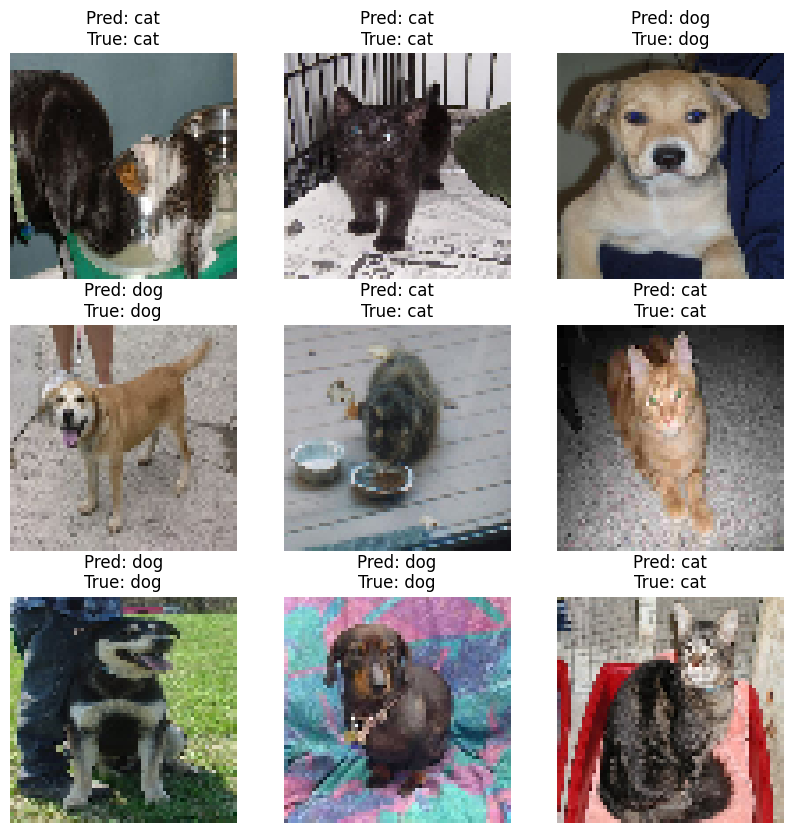

In [ ]:

if __name__ == "__main__":
    df = load_and_clean_data()
    
    train_generator, validation_generator = create_generators(df)
    
    model, history = build_and_train_model(train_generator, validation_generator)
    
    evaluate_and_visualize(model, validation_generator)